In [113]:
## NOTE!!!!
## We had difficulties using R in the jupyterlab environment (access data on S3, use the sf-package, etc.) 
## The code in this notebook was copied our local RStudios and therefore will not run here without fixing 
## the remaining issues.

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [9]:
#Libraries 
library(tmap)
library(tidyr)
library(ggplot2)
library(lubridate)
library(transformr)
library(dplyr)
library(zoo)
library(tidyverse)
library(aws.s3)
library(eurostat)
library(sf)
library(tmaptools)
library(terra)
library(factoextra)
library(NbClust)
library(ggthemes)
library("maps")
library("ggplot2")

In [10]:
# LOAD DATA 
## Map Data
nuts3_sf <- get_eurostat_geospatial(output_class = 'sf', 
                                    resolution ='60', 
                                    nuts_level = 3,
                                    year = 2016,
                                    crs = 4326)
## Import climate variables
data <- read.csv('preproc_seasonalv3.csv')



sf at resolution 1:60 read from local file

Warning message in get_eurostat_geospatial(output_class = "sf", resolution = "60", :
“Default of 'make_valid' for 'output_class="sf"' will be changed in the future (see function details).”


In [11]:
##Data transforation : selecting appropriate variables and taking the mean per year over the NUTS3
data_kmeans = data %>% 
  filter(sector %in% c("A")) %>%
  filter(year!="2002")%>%
  select(-c("X","area","sector","gdp","GVA","employment","population") )%>%
  select("geo", "LFI_WINTER", "LFI_SPRING", "LFI_SUMMER", "LFI_FALL", "APAR_WINTER", "APAR_SPRING", "APAR_SUMMER", "APAR_FALL", "SMA_WINTER",  "SMA_SPRING", "SMA_SUMMER", "SMA_FALL", "SPI_WINTER", "SPI_SPRING", "SPI_SUMMER" , "SPI_FALL","TMAX_WINTER_normal","TMAX_SPRING_normal","TMAX_SUMMER_normal","TMAX_FALL_normal","hi_WINTER","hi_SPRING","hi_SUMMER","hi_FALL" )%>% #,,"hi_WINTER","hi_SPRING","hi_SUMMER","hi_FALL" "SPI_WINTER","SPI_SPRING","SPI_SUMMER","SPI_FALL","TMAX_WINTER","TMAX_SPRING","TMAX_SUMMER","TMAX_FALL")%>% 
  group_by(geo)%>% #MAX_HI
  summarise_all(mean, na.rm=T)


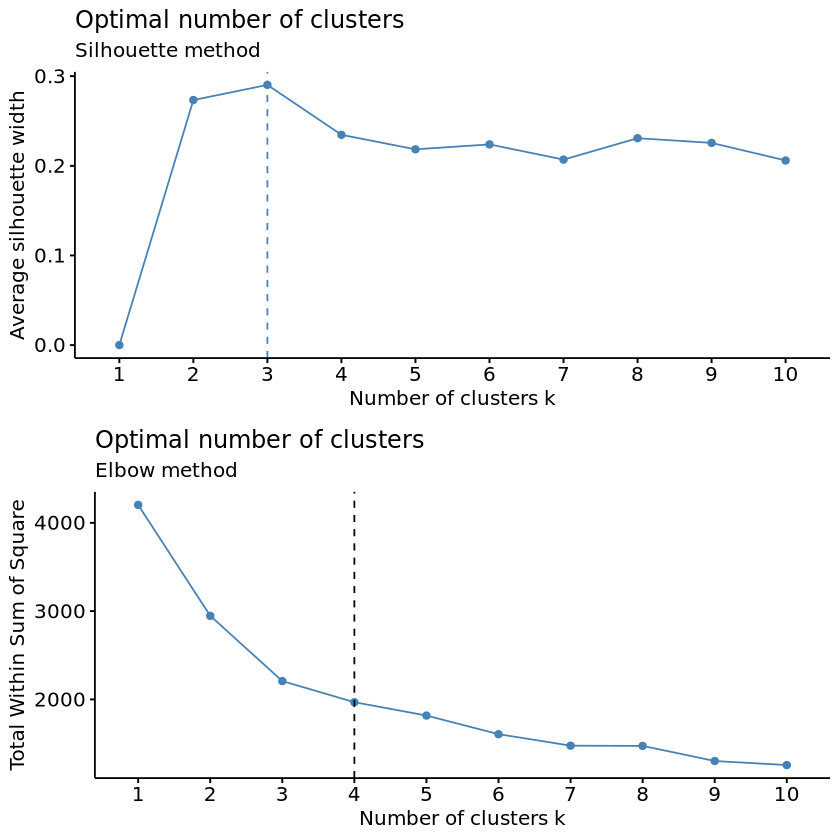

In [12]:
## Optimal number of clusters :  threee methods, elbow, silhouette and Gap statistic
# Elbow method
elbow= fviz_nbclust(data_kmeans[,-1] %>% na.omit(), kmeans, method = "wss") +
  geom_vline(xintercept = 4, linetype = 2)+
  labs(subtitle = "Elbow method")

# Silhouette method
silh = fviz_nbclust(data_kmeans[,-1]%>% na.omit(), kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")

# Gap statistic
set.seed(123)
#gap = Gap_stat = fviz_nbclust(data_kmeans[,-1], kmeans, nstart = 25,  method = "gap_stat", nboot = 50, k.max = 15)+
# labs(subtitle = "Gap statistic method")
 

gridExtra::grid.arrange(silh,elbow)
# --> choice of 10 catégories 

In [13]:
## Running chocen KMEANS
km.res <- kmeans(data_kmeans[,-1]%>% na.omit(), 10, nstart = 50)
temp = data.frame(geo=data_kmeans%>% na.omit()%>%select(geo),cluster=km.res$cluster)
data_kmeans=data_kmeans %>% left_join(temp)


Joining with `by = join_by(geo)`


In [14]:
## Mapping the clusters
data_map <- inner_join(data_kmeans, nuts3_sf, by = c("geo")) 

ggplot(data_map) +
  geom_sf(aes(fill = as.factor(cluster), geometry = geometry)) +
  #scale_fill_viridis(option = "A", direction = -1) +  # Adjust the color scale
  theme_minimal() +
  xlim(-20,35)+
  ylim(30,70)



In [15]:
## Plot the correlations
aggregate(data_kmeans[,-1], list(data_kmeans$cluster), mean)


Group.1 LFI_WINTER LFI_SPRING LFI_SUMMER LFI_FALL   APAR_WINTER APAR_SPRING
1   1      0.08697488 0.08541636 0.08048591 0.07131801 0.2395081   0.29790896 
2   2      0.07501732 0.10313750 0.08890339 0.08689206 0.1720055   0.06337024 
3   3      0.09093661 0.09932140 0.10253650 0.10792521 0.2578323   0.18001465 
4   4      0.13803421 0.14371075 0.13556250 0.11812873 0.1188566   0.12349774 
5   5      0.10658227 0.13719707 0.12507228 0.10038584 0.1874393   0.12269339 
6   6      0.13821939 0.12680221 0.13620653 0.12235340 0.1591796   0.10527925 
7   7      0.12725495 0.13418958 0.12852526 0.11638698 0.2183283   0.21347738 
8   8      0.16121189 0.14711814 0.15197332 0.13339761 0.1720906   0.13715796 
9   9      0.11788235 0.13728615 0.18849449 0.15172733 0.2758368   0.30693557 
10 10      0.11107870 0.14832110 0.16099306 0.12442361 0.0180045   0.12858201 
   APAR_SUMMER APAR_FALL SMA_WINTER   ⋯ SPI_FALL    TMAX_WINTER_normal
1  0.2977556   0.2781166  0.090491115 ⋯ -0.01578125 0.9892703         
2  0.1214500   0.2609269  0.103561328 ⋯ -0.20642930 0.9666141         
3  0.2132007   0.3143913  0.133252493 ⋯ -0.19130689 0.9709490         
4  0.2233484   0.2332717  0.025646053 ⋯ -0.10922632 0.9848598         
5  0.1003285   0.2363321  0.003058248 ⋯ -0.23713935 0.9708372         
6  0.1689683   0.2764392 -0.013256687 ⋯ -0.24747029 0.9845312         
7  0.1911155   0.2599167  0.034551562 ⋯ -0.11162539 0.9790408         
8  0.2507666   0.3005668 -0.061995935 ⋯ -0.23129611 0.9920767         
9  0.1466078   0.2890840  0.036750613 ⋯ -0.17675643 0.9891765         
10 0.1987778   0.1670741  0.053556548 ⋯ -0.07519643 0.9725133         
   TMAX_SPRING_normal TMAX_SUMMER_normal TMAX_FALL_normal hi_WINTER hi_SPRING
1  0.9988248          1.0013606          1.003471         2.2641168 0.8600839
2  1.0067252          1.0000038          1.005926         3.0831362 1.4841006
3  1.0067468          1.0000653          1.006025         2.1694933 0.8943865
4  1.0006677          1.0028992          1.005091         0.7099923 0.6972343
5  1.0026994          1.0010822          1.005006         2.5449146 1.3140091
6  1.0014221          1.0037197          1.004559         0.9692266 1.1241078
7  1.0000136          1.0017504          1.004230         1.7545286 2.0299697
8  1.0009062          1.0035756          1.005186         0.5887005 0.8117877
9  0.9997106          1.0029870          1.003048         1.0448940 3.0815148
10 0.9973619          0.9977852          1.012688         3.9786097 2.0255593
   hi_SUMMER hi_FALL   cluster
1  2.0084900 0.6348642  1     
2  2.1931217 3.1059892  2     
3  0.9319850 1.5273413  3     
4  0.8144691 0.5316467  4     
5  3.7036089 2.3549130  5     
6  4.0642035 1.3387546  6     
7  2.4107960 1.8981264  7     
8  2.2280868 0.8316433  8     
9  4.6624991 1.3269049  9     
10 2.3257374 1.3056037 10

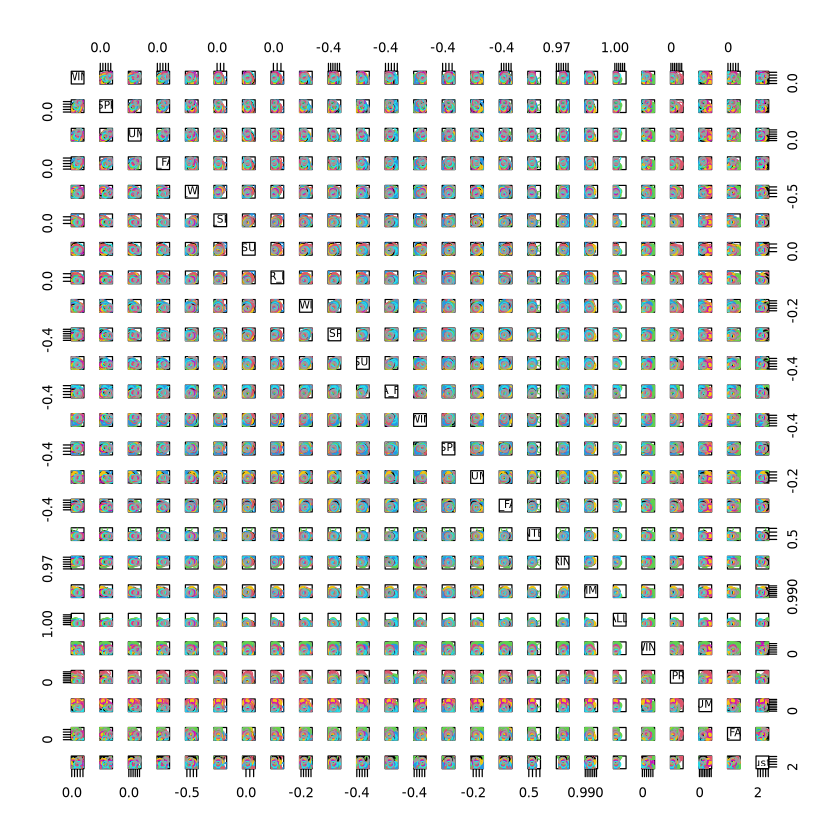

In [16]:
with(data_kmeans[,2:20], pairs(data_kmeans[,-1], col=c(2:20)[data_kmeans$cluster]))

In [17]:
## Output the clusters
NUTS = data %>%
  select(geo)%>%
  unique() %>%
  left_join(data_kmeans) 

  
NUTS$cluster[is.na(NUTS$cluster)] = 11

NUTS = NUTS %>% select(geo, cluster)
#write.csv(NUTS,'/cluster_climate_variables.csv')


Joining with `by = join_by(geo)`
